In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from fastai.data.core import DataLoaders
from torch.utils.data import random_split
from fastai.vision.all import *



In [3]:

base_path = "facial/"
training_path = base_path + "training/"
test_path = base_path + "test/"

df = pd.read_csv(training_path + 'training.csv', nrows=10000)
test_df = pd.read_csv(test_path + 'test.csv', nrows=100000)


In [4]:
attributes = ['nose_tip', 'left_eye_center', 'right_eye_center']
considered_columns = reduce(lambda x, y: x + y, [ [x + '_x', x + '_y'] for x in attributes])
considered_columns

['nose_tip_x',
 'nose_tip_y',
 'left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y']

In [5]:
df.shape

(7049, 31)

In [6]:
# Replace 'column_name' with the actual column name you want to check
df = df.dropna(subset=considered_columns)
df.shape


(7033, 31)

In [7]:
import os

already_there = os.path.exists(training_path + '/0.png')
for index, row in df.iterrows():
    file_path = training_path + f'{index}.png'
    if not already_there:
        img_array = np.fromstring(row['Image'], sep=' ').reshape(96, 96).astype(np.uint8)
        pil_image = Image.fromarray(img_array)
        pil_image.convert('L').save(file_path)
    df.loc[index, 'Image'] = file_path
df.Image

0          facial/training/0.png
1          facial/training/1.png
2          facial/training/2.png
3          facial/training/3.png
4          facial/training/4.png
                  ...           
7044    facial/training/7044.png
7045    facial/training/7045.png
7046    facial/training/7046.png
7047    facial/training/7047.png
7048    facial/training/7048.png
Name: Image, Length: 7033, dtype: object

In [8]:
get_image_files(training_path)

(#7033) [Path('facial/training/3581.png'),Path('facial/training/2229.png'),Path('facial/training/6064.png'),Path('facial/training/5866.png'),Path('facial/training/5862.png'),Path('facial/training/1389.png'),Path('facial/training/3461.png'),Path('facial/training/900.png'),Path('facial/training/5627.png'),Path('facial/training/5139.png')...]

In [9]:
from pathlib import PosixPath

# Prepare the data
# Convert the images to a format suitable for fastai
def get_y(r):
    return [
    [r['nose_tip_x'].item(),r['nose_tip_y'].item()],
    [r['left_eye_center_x'].item(),r['left_eye_center_y'].item()],
    [r['right_eye_center_x'].item(),r['right_eye_center_y'].item()],
    ]

def my_get_y(f: PosixPath):
    res = get_y(df[df['Image'] == str(f)])
    return res

def my_x(x):
    #print (x)
    return x

batch_tfms = [Flip(), Rotate(), Zoom(), Warp()]

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=my_get_y,
    get_x=my_x,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(96),
    batch_tfms=batch_tfms
)

dblock.summary(training_path)



Setting-up type transforms pipelines
Found 7033 items
2 datasets of sizes 5627,1406
Setting up Pipeline: my_x -> PILBase.create
Setting up Pipeline: my_get_y -> TensorPoint.create

Building one sample
  Pipeline: my_x -> PILBase.create
    starting from
      facial/training/562.png
    applying my_x gives
      facial/training/562.png
    applying PILBase.create gives
      PILImage mode=RGB size=96x96
  Pipeline: my_get_y -> TensorPoint.create
    starting from
      facial/training/562.png
    applying my_get_y gives
      [[49.9966792453, 45.7046943396], [74.2816603774, 31.6734792453], [27.8707924528, 31.6734792453]]
    applying TensorPoint.create gives
      TensorPoint of size 3x2

Final sample: (PILImage mode=RGB size=96x96, TensorPoint([[49.9967, 45.7047],
             [74.2817, 31.6735],
             [27.8708, 31.6735]]))


Found 7033 items
2 datasets of sizes 5627,1406
Setting up Pipeline: my_x -> PILBase.create
Setting up Pipeline: my_get_y -> TensorPoint.create
Setting up 

In [10]:
dls = dblock.dataloaders(training_path)

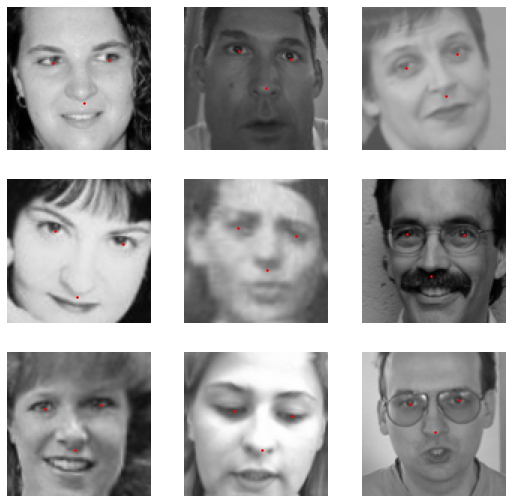

In [11]:
dls.show_batch()

In [12]:
xb,yb = dls.one_batch()

In [13]:
xb.shape,yb.shape

(torch.Size([64, 3, 96, 96]), torch.Size([64, 3, 2]))

TensorPoint(-0.0485)
TensorPoint(-0.4360)
TensorPoint(0.2843)


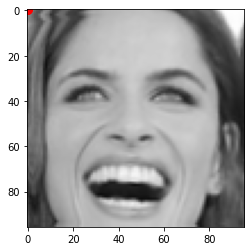

In [14]:

idx = 9

image = xb[idx].cpu().permute(1, 2, 0)
plt.imshow(image, )

y = yb[idx].cpu()
for p in y:
    print(p[0])
    plt.scatter(p[0], p[1], c='red')
#plt.scatter(row['left_eye_center_x'], row['left_eye_center_y'], c='red')
#plt.scatter(row['right_eye_center_x'], row['right_eye_center_y'], c='blue')
#plt.scatter(row['nose_tip_x'], row['nose_tip_y'], c='green')
#plt.scatter(row['mouth_center_bottom_lip_x'], row['mouth_center_bottom_lip_y'], c='purple')
#plt.scatter(row['mouth_left_corner_x'], row['mouth_left_corner_y'], c='orange')
            #right_eye_center_x	right_eye_center_y)
#plt.show()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(minimum=0.010000000149011612, steep=0.033113110810518265, valley=0.00363078061491251, slide=0.0004786300996784121)

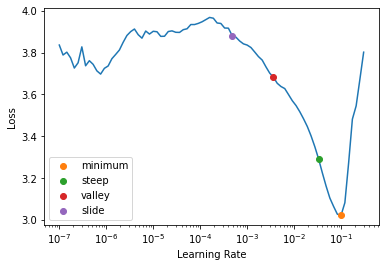

In [15]:
# Define the model
learn = vision_learner(dls, resnet34, loss_func=MSELossFlat())
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,time
0,1.795290,0.300534,00:11
1,0.484042,0.079737,00:11
2,0.184511,0.068013,00:11


SuggestedLRs(minimum=0.0019054606556892395, steep=0.0063095735386013985, valley=0.001737800776027143, slide=0.0030199517495930195)

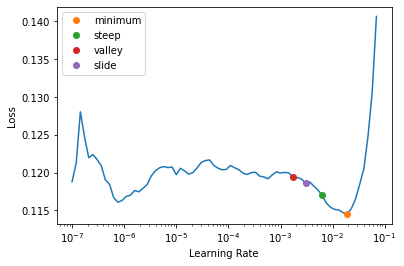

In [16]:
learn.freeze()
learn.fit_one_cycle(3, 3e-3)
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [18]:

learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,time
0,0.071980,0.058532,00:13
1,0.069508,0.056389,00:12
2,0.066502,0.055411,00:12
3,0.065152,0.053411,00:12
4,0.064221,0.052666,00:12
5,0.063770,0.052843,00:14


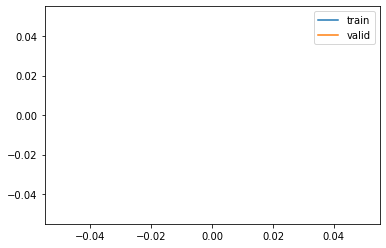

In [20]:
learn.recorder.plot_loss()

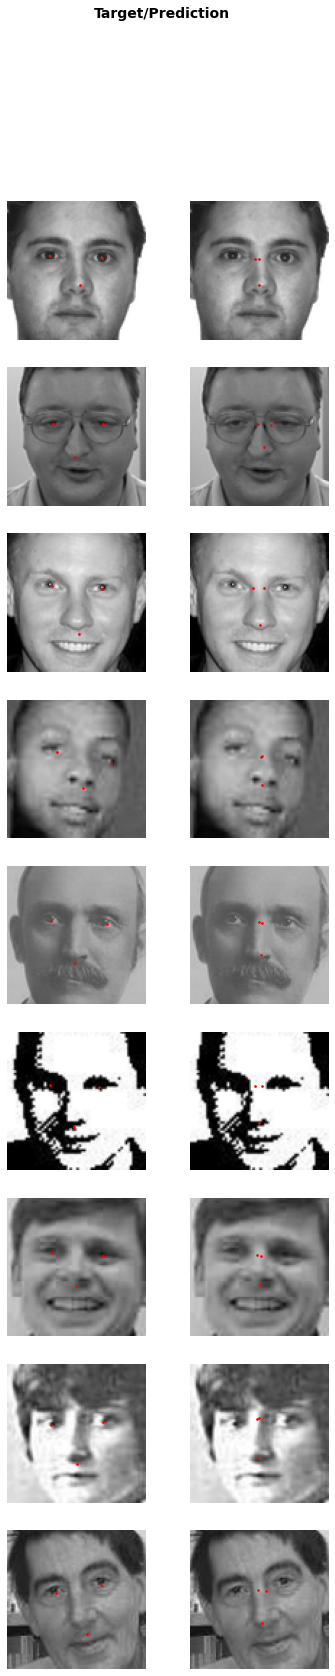

In [21]:
learn.show_results()